# Imports and Setting up Plotting

In [1]:
from datetime import date, timedelta
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

rcParams = {'figure.max_open_warning': 0,
            'figure.figsize': (15, 8),
            'axes.grid': True}

plt.rcParams.update(rcParams)
plt.style.use('bmh')

pd.options.display.max_rows = 50

# Loading Data

In [9]:
# Reading CSV files and Loading the data
# filepath = r'c:\src\interview_project_data\*.csv' # change to my own file path
filepath = './*.csv'
csv_files = glob.glob(filepath)

data = {}

for csv_file in csv_files:
    print('Loading ', csv_file)
#     data_key = csv_file.rsplit('\\', 1)[-1].split('.')[0]    # change to mac separator
    data_key = csv_file.rsplit('/', 1)[-1].split('.')[0]    # change to mac separator

    df = pd.read_csv(csv_file)
    df.set_index('dates', inplace=True)
    df.index = pd.to_datetime(df.index)
    data[data_key] = df
    
asset_prices = data['asset_prices']

# Firstly Grab the data by country
countries = ['US', 'CA']
data_labels = ['Unemployment', 'IndustrialProduction', 'GDP', 'HomeSales']

economic_data = {}

for country in countries:
    tmp_data = {}

    for label in data_labels:
        tmp_data[f'{label}'] = data[f'{country}_{label}']

    economic_data[f'{country}'] = tmp_data

Loading  ./CA_Unemployment.csv
Loading  ./CA_IndustrialProduction.csv
Loading  ./US_Unemployment.csv
Loading  ./US_HomeSales.csv
Loading  ./asset_prices.csv
Loading  ./US_IndustrialProduction.csv
Loading  ./US_GDP.csv
Loading  ./CA_GDP.csv
Loading  ./CA_HomeSales.csv


## Examining Data

In [10]:
asset_prices

,ES1 Index,PT1 Index,CADUSD Curncy,DXY Curncy
dates,,,,
1980-01-01,NaN,NaN,0.8559,85.820
1980-01-02,NaN,NaN,0.8578,85.320
1980-01-03,NaN,NaN,0.8545,85.260
1980-01-04,NaN,NaN,0.8557,85.230
1980-01-07,NaN,NaN,0.8551,84.790
...,...,...,...,...
2023-01-20,3988.50,1237.2,0.7474,102.012
2023-01-23,4036.50,1244.9,0.7481,102.138
2023-01-24,4032.75,1244.1,0.7480,101.918


In [11]:
economic_data

{'US': {'Unemployment':             actual_value  expected_value  number_of_forecaster
  dates                                                         
  1997-02-07           5.4             5.3                   0.0
  1997-03-07           5.3             5.3                   0.0
  1997-04-04           5.2             5.2                   0.0
  1997-05-02           4.9             5.2                   0.0
  1997-06-06           4.8             5.0                   0.0
  ...                  ...             ...                   ...
  2022-05-06           3.6             3.5                  76.0
  2022-06-03           3.6             3.5                  69.0
  2022-07-08           3.6             3.6                  74.0
  2022-08-05           3.5             3.6                  71.0
  2022-09-02           3.7             3.5                  71.0
  
  [307 rows x 3 columns],
  'IndustrialProduction':             actual_value  expected_value  number_of_forecaster
  dates        

# Building An Indicator

In this example, we assume that the growth rate of GDP is a good indication of the growth of a country's economy. For illustrative and simplicity reasons, we will focus on only this data. With this assumption, again for simplicity, we propose our indicator as just the actual value of GDP growth rate.

In [12]:
us_gdp = economic_data['US']['GDP']['actual_value']  # US GDP growth rate
ca_gdp = economic_data['CA']['GDP']['actual_value']  # Canada GDP growth rate

gdp = pd.concat([us_gdp, ca_gdp], axis=1, sort=True, keys=['US', 'CA'])

In [13]:
# our economic indicator is just the GDP growth rate
ca_indicator = ca_gdp
us_indicator = us_gdp

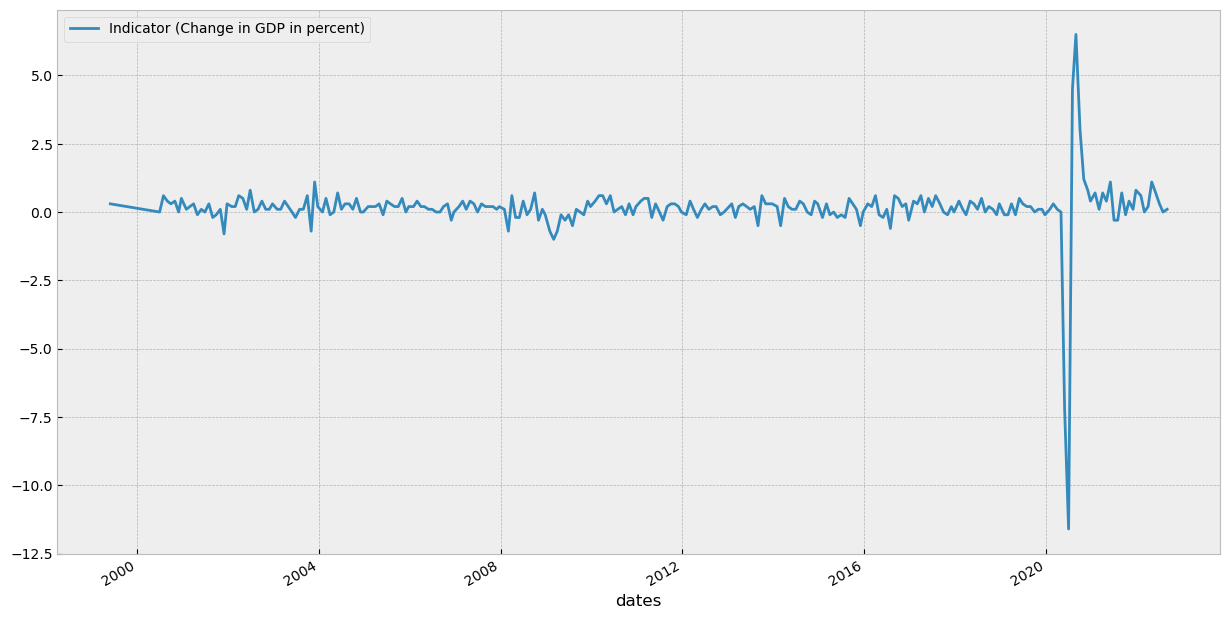

In [14]:
ca_indicator.plot(label='Indicator (Change in GDP in percent)')
plt.legend()

# Building a Trading Signal Using the Indicator

Using the indicator that we have created, we then try to create a trading signal.

We start by thinking how we can trade this strategy.

The most simplistic use of the indicator to trade would be using the indicator as the trading signal without any transformation. In our example, that would mean buy (go long) when the change in GDP is positive, and sell (go short) when the change in GDP is negative. This approach is shown in basic_signal() below.

We encourage you to try some new signals. As an example of how a signal might look like, you can look at the momentum trading signal in the Software Engineering project (Project 1).

In [15]:
def basic_signal(ts):
    # ts is a vector
    signal = pd.DataFrame(np.zeros((len(ts.index), 1)),index=ts.index, columns=['signal'])
    signal[ts > 0] = 1
    signal[ts < 0] = -1
    
    return signal

In [16]:
ca_sgnl = basic_signal(ca_gdp)
us_sgnl = basic_signal(us_gdp)

## Show Performance of the Trading Signal

### Choose the assets you want to trade

In [17]:
# In this case, we are postulating that when the change in GDP is positive,
# both the country's stock market and the country's currency will rise.
ca_assets = ['PT1 Index', 'CADUSD Curncy']
us_assets = ['ES1 Index', 'DXY Curncy']

### Calculate PnL

In [18]:
def calculate_pnl(ret, pos):
    # function to calculate profit and loss
    # we trade at the end of the period, and take profit & loss on the market move next period on our position
    # that's why we are shifting positon vector by one
    return ret.multiply(pos.shift(), axis=0).dropna()

In [19]:
# build the return series for each of the series
ca_returns = asset_prices[ca_assets].pct_change()
us_returns = asset_prices[us_assets].pct_change()

# Resample the Signal into daily signal
ca_daily_pos = ca_sgnl.resample('D').ffill()
us_daily_pos = us_sgnl.resample('D').ffill()

In [21]:
ca_sgnl.resample('D')

In [22]:
us_pnl = calculate_pnl(us_returns, us_daily_pos['signal'])
ca_pnl = calculate_pnl(ca_returns, us_daily_pos['signal'])

<AxesSubplot:title={'center':'Cumulative Trading Profit'}, xlabel='dates'>

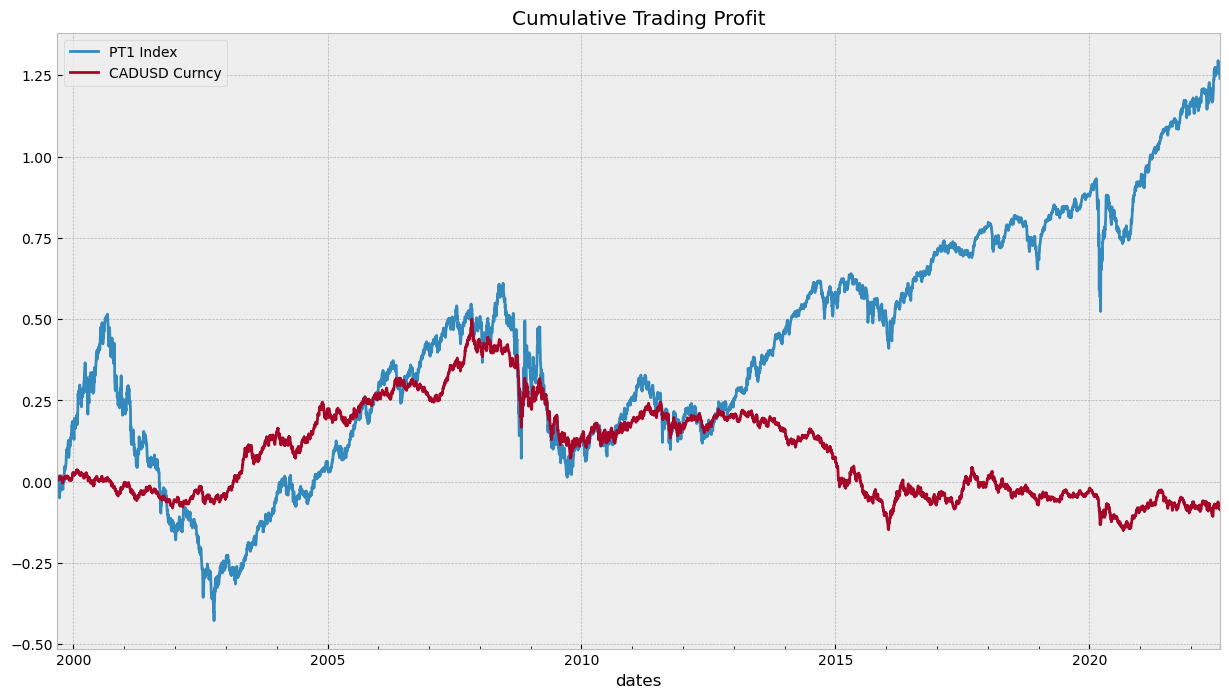

In [23]:
ca_pnl.cumsum().plot(title='Cumulative Trading Profit')

<AxesSubplot:title={'center':'Cumulative Trading Profit'}, xlabel='dates'>

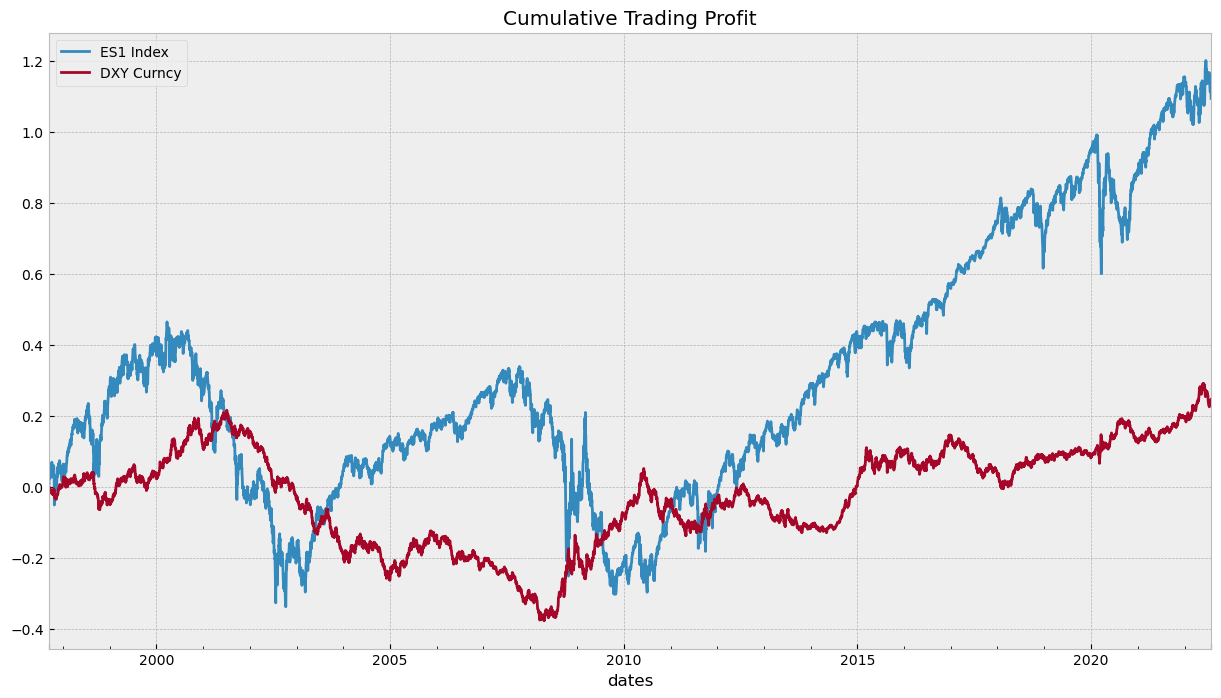

In [24]:
us_pnl.cumsum().plot(title='Cumulative Trading Profit')

## Some thoughts on the performance of the trading signal

Please examine the results of your trading signal and provide some commentary on the performance. 

If it performs well. Why? If it doesn't, why not? How can you make it better? 

What would be the next steps, if on the job, you are asked to further explore this investigation?

# 1. Economic Indicator

The economic data given provides growth data on {production, home sales, unemployment rate, and GDP}

GDP growth and unemployment are both lagging indicators, while production and home sales are leading indicators

I'm going to explore the pair of leading indicators {production, home sales} as leading indicators have prediction power which can come convenient to building a trading signal later.

In [46]:
ca_production = economic_data['CA']['IndustrialProduction']['actual_value']
us_production = economic_data['US']['IndustrialProduction']['actual_value']
ca_home_sales = economic_data['CA']['HomeSales']['actual_value']
us_home_sales = economic_data['US']['HomeSales']['actual_value']

Explore the data

In [41]:
ca_production

dates
1997-03-17    2.2
1997-04-16    0.6
1997-05-16    0.4
1997-06-27    0.5
1997-07-16   -0.2
             ... 
2022-04-14    4.2
2022-05-16    2.5
2022-06-14    1.7
2022-07-14   -2.0
2022-08-15   -0.8
Name: actual_value, Length: 306, dtype: float64

In [33]:
us_production

dates
1997-02-14    0.0
1997-03-14    0.5
1997-04-16    0.9
1997-05-15    0.0
1997-06-17    0.4
             ... 
2022-04-15    0.9
2022-05-17    1.1
2022-06-17    0.2
2022-07-15   -0.2
2022-08-16    0.6
Name: actual_value, Length: 307, dtype: float64

In [34]:
ca_home_sales

dates
2000-08-09    165.500
2000-09-11    146.000
2000-10-10    156.000
2000-11-08    164.800
2000-12-08    155.800
               ...   
2022-04-19    246.243
2022-05-16    267.330
2022-06-15    287.257
2022-07-18    273.841
2022-08-16    275.329
Name: actual_value, Length: 264, dtype: float64

In [35]:
us_home_sales

dates
2005-06-01    3.6
2005-07-06   -2.0
2005-08-01    0.6
2005-09-01   -1.0
2005-10-05    3.2
             ... 
2022-04-27   -1.2
2022-05-26   -3.9
2022-06-27    0.7
2022-07-27   -8.6
2022-08-24   -1.0
Name: actual_value, Length: 208, dtype: float64

In [48]:
# Seems like Canadian Home Sales is not a growth series
ca_home_sales_growth = ca_home_sales.pct_change().fillna(0) * 100
ca_home_sales_growth

dates
2000-08-09     0.000000
2000-09-11   -11.782477
2000-10-10     6.849315
2000-11-08     5.641026
2000-12-08    -5.461165
                ...    
2022-04-19    -0.409697
2022-05-16     8.563492
2022-06-15     7.454083
2022-07-18    -4.670382
2022-08-16     0.543381
Name: actual_value, Length: 264, dtype: float64

<AxesSubplot:title={'center':'US Home Sales'}, xlabel='dates'>

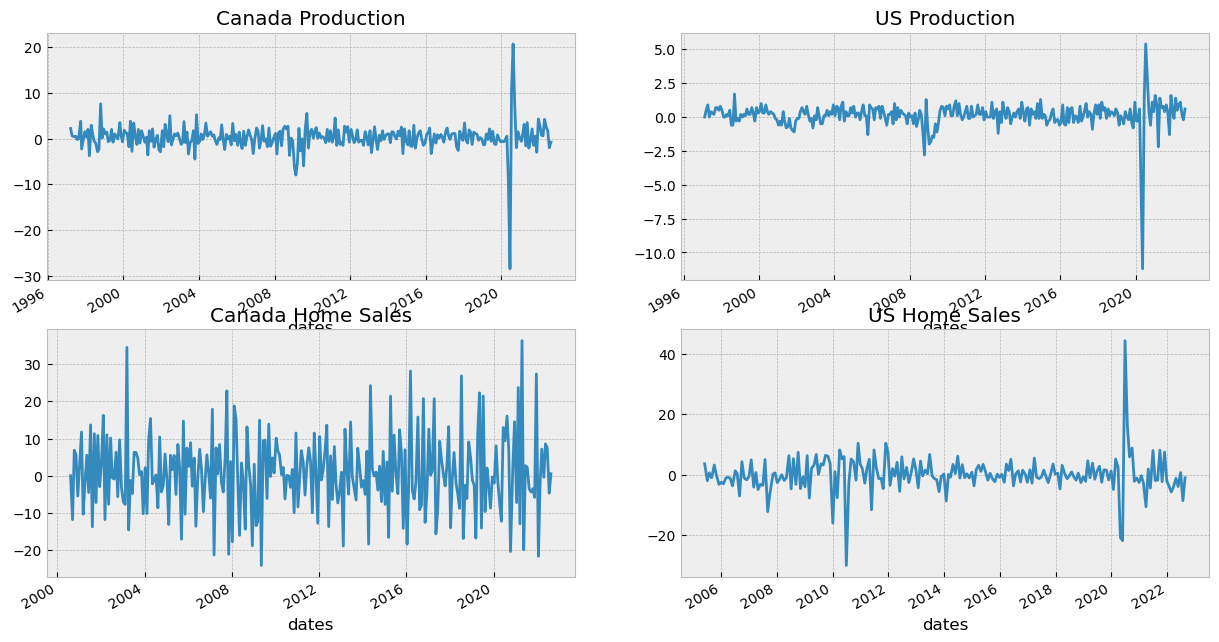

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=2)

ca_production.plot(ax=axes[0,0], title='Canada Production')
us_production.plot(ax=axes[0,1], title='US Production')
ca_home_sales_growth.plot(ax=axes[1,0], title='Canada Home Sales')
us_home_sales.plot(ax=axes[1,1], title='US Home Sales')

## 1a. Production vs Home Sales

Production output are usually a good indicator of the strength of economy in the near future, as strong manufacturing increase the availability of goods and enables an increase of sales later; this directly boosts the GDP and is great for the economy; however, if not paired with strong purchase power, the increased availability of goods do not convert into sales, but rather inventory backlogs. 

The Home Sales data, though does not tell us directly about retail sales volume, should show the consumer confidence quite well. Confident consumers would be more willing to spend, providing the complementary info to production data.

I'm going to explore ways to combine these two.

In [51]:
# Push both data to month end to avoid lookahead bias
# Try sum-of-rolling-z-score 
#     Evaluate effectiveness of this indicator to predict GDP

